In [23]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn.functional as F

In [5]:
def generate_gaussian(labels, sigma=1, resol=46):
    """
    cpu version of generate_gaussian_groundtruth. 4x speed up.
    Implemented on 10/26/2018. Works fine.

    Args: 
        labels, torch.Tensor, 21*2, first column is x(horizontal),
                second column is y(vertical, from top to bottom)

    Returns:
        heatmaps, torch.Tensor, 21*46*46   
    """
    #labels = torch.from_numpy(labels).float().cuda()
    labels = labels
    # construct 3-D tensor a, which stores (column(x), row(y)) for each pixel 
    a = torch.zeros((resol,resol,2))
    a[...,0] = a[...,0] + torch.Tensor(range(resol)).unsqueeze(0)
    a[...,1] = a[...,1] + torch.Tensor(range(resol)).unsqueeze(1)
    a = a.unsqueeze(0)
    labels = labels.unsqueeze(-2).unsqueeze(-2)
    exponent = torch.sum((a - labels)**2, dim=-1)
    heatmaps = torch.exp(-exponent / 2.0 / sigma / sigma)
    return heatmaps

In [51]:
label = torch.Tensor([[16,22]])
a = generate_gaussian(label,resol=45).squeeze()

In [52]:
a.shape

torch.Size([45, 45])

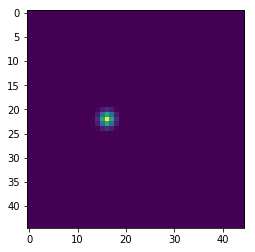

In [53]:
plt.imshow(a.numpy())

In [54]:
b = torch.zeros((46,46))
b[15:35,15:35] = 1

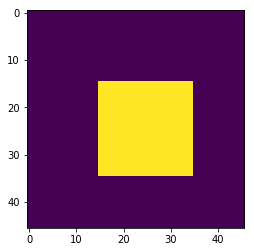

In [55]:
plt.imshow(b.numpy())

In [56]:
a.shape, b.shape

(torch.Size([45, 45]), torch.Size([46, 46]))

In [57]:
conv_ab = F.conv2d(b.unsqueeze(0).unsqueeze(0), a.unsqueeze(0).unsqueeze(0),stride=1,padding=22)

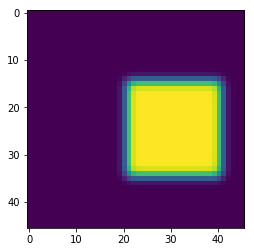

In [58]:
plt.imshow(conv_ab.squeeze().numpy())

In [59]:
a =[
    12, #dafa
    23,
    35, #daf
]

In [60]:
a

[12, 23, 35]

In [62]:
    
import torch
from torch import nn
import torch.nn.functional as F

In [63]:
class TreeModel(nn.Module):
    """
        0---1---2---3---4
        |---5---6---7---8
        |---9---10---11---12
        |---13---14---15---16
        |---17---18---19---20
    """
    def __init__(self):
        super().__init__()
        batch_size = 4
        self.kernel_size = 45
        self.kernels = torch.randn(batch_size, 40, int(self.kernel_size), int(self.kernel_size)) # batch_size, 20x2 edges (upwards and downwards). 45x45 resolution
        self.bias = torch.zeros(batch_size,40)
        self.edges = {
                    'upwards': [[4,3], [3,2], [2,1], [1,0],       # thumb
                                [8,7], [7,6], [6,5], [5,0],       # index finger    
                                [12,11], [11,10], [10,9],[9,0],   # middle finger
                                [16,15],[15,14],[14,13],[13,0],   # ring finger
                                [20,19],[19,18],[18,17],[17,0]    # little finger
                    ],
                    'downwards':[[0,1], [1,2], [2,3], [3,4],
                                 [0,5], [5,6], [6,7], [7,8],
                                 [0,9], [9,10],[10,11],[11,12],
                                 [0,13], [13,14],[14,15],[15,16],
                                 [0,17],[17,18],[18,19],[19,20]
                    ]
        }

In [64]:
treemodel = TreeModel()

In [66]:
treemodel.cuda()

TreeModel()

In [78]:
x= torch.tensor([5.],requires_grad=True)

In [79]:
x.requires_grad

True

In [80]:
y = x**2

In [81]:
y.backward()

In [82]:
x.grad

tensor([10.])

In [84]:
z = torch.tensor([4.], requires_grad=True)

In [90]:
w = torch.zeros(2)

In [91]:
w

tensor([0., 0.])

In [92]:
w[0] = z**2

In [94]:
w[0].backward()

In [95]:
z.grad

tensor([8.])

In [98]:
directed_edges = [                       # start of schedule from leaves to root
                        [[4,3], []],     # edge 0, [[from_joint=4, to_joint=3],[empty other incoming edge]]
                        [[3,2], [0]],    # edge 1
                        [[2,1], [1]],    # edge 2
                        [[1,0], [2]],    # edge 3

                        [[8,7], []],     # edge 4
                        [[7,6], [4]],    # edge 5
                        [[6,5], [5]],    # edge 6
                        [[5,0], [6]],    # edge 7

                        [[12,11], []],   # edge 8
                        [[11,10], [8]],  # edge 9
                        [[10,9], [9]],   # edge 10
                        [[9,0], [10]],   # edge 11

                        [[16,15], []],   # edge 12
                        [[15,14], [12]], # edge 13
                        [[14,13], [13]], # edge 14
                        [[13,0], [14]],  # edge 15

                        [[20,19], []],   # edge 16
                        [[19,18], [16]], # edge 17
                        [[18,17], [17]], # edge 18
                        [[17,0], [18]],  # edge 19   # end of schedule from leaves to root

                        [[0,1], [7, 11, 15, 19]], # edge 20  # start of schedule from root to leaves
                        [[1,2], [20]],   # edge 21
                        [[2,3], [21]],   # edge 22
                        [[3,4], [22]],   # edge 23

                        [[0,5], [3,11,15,19]],  # edge 24
                        [[5,6], [24]],   # edge 25
                        [[6,7], [25]],   # edge 26
                        [[7,8], [26]],   # edge 27

                        [[0,9], [3,7,15,19]],   # edge 28
                        [[9,10], [28]],  # edge 29
                        [[10,11], [29]], # edge 30
                        [[11,12], [30]], # edge 31

                        [[0,13], [3,7,11,19]],   # edge 32
                        [[13,14], [32]], # edge 33
                        [[14,15], [33]], # edge 34
                        [[15,16], [34]], # edge 35

                        [[0,17], [3,7,11,15]],   # edge 36
                        [[17,18], [36]], # edge 37
                        [[18,19], [37]], # edge 38
                        [[19,20], [38]]  # edge 39         # end of schedule from root to leaves 
                    ]

In [104]:
    def mul_by_log_exp(*args):
        """
        Performs multiplication by taking log first then take exp.
        Returns a scaled product of the args.

        Args:
            bs x 1 x 45 x 45
        """
        # log_y = torch.log(args[0]+1e-16)
        # for x in args[1:]:
        #     log_y = log_y + torch.log(x+1e-16)
        return sum(args)
        

In [113]:
mul_by_log_exp(13,15,*[3])

31

In [108]:
x = torch.zeros(4,5)

In [109]:
x

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [110]:
y = torch.zeros(x.shape)

In [111]:
y

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [125]:
def normalize_prob( x):
    """
    Normalize along last two dimensions
    """

    return x/torch.sum(x,dim=[-1,-2],keepdim=True)

In [126]:
x = torch.tensor([[2.,4.],[6.,8.]])

In [127]:
x

tensor([[2., 4.],
        [6., 8.]])

In [124]:
normalize_prob( x)

tensor([[0.1000, 0.2000],
        [0.3000, 0.4000]])

In [128]:
torch.ones(5,5)

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

In [131]:
torch.tensor([[22.,22.]]).shape

torch.Size([1, 2])